In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import copy
from os.path import join
from os import stat
from mpl_toolkits import mplot3d as mpl3
from matplotlib.animation import FuncAnimation

# Number of joints used.
NUM_JOINTS = 20

# File directory for the data. Should point to the directory that contains all of the SIDs (numbered folders).
FILE_DIRECTORY = "Data Collection\\Data\\data\\data\\Data"

## Read in data from all SIDs in the path

In [2]:
dirs = glob.glob(join(FILE_DIRECTORY,"*",""))
data_dict = {}
for d_path in dirs:
    d_name = d_path.rsplit(maxsplit=2,sep="\\")[1]
    data_dict[d_name] = []
    for data_file in glob.glob(join(d_path,"*.txt")):
        dfile_name = data_file.rsplit(maxsplit=1,sep="\\")[1]
        if stat(data_file).st_size > 0:
            df = pd.read_csv(data_file,header=None,sep=";")
            trl_lines = len(df) % NUM_JOINTS
            if trl_lines is not 0:
                end_idx = len(df) - trl_lines
                print("File '%s' has %d trailing lines, ignoring." % (data_file,trl_lines))
                df = df[:end_idx]
            frames = np.reshape(df.values[:,1:4],(-1,NUM_JOINTS,3)).astype(np.float32)
            data_dict[d_name].append((frames,dfile_name))
        else:
            print("File '%s' is empty, ignoring." % data_file)
print("Read complete.")

File 'Data Collection\Data\data\data\Data\0892045890\f-_20170510114650665.txt' is empty, ignoring.
File 'Data Collection\Data\data\data\Data\7696895508\f-S1_20170425121901382.txt' has 1 trailing lines, ignoring.
Read complete.


## Build Animation Update Function

In [3]:
def update_func(frame_num,data,plot,mp,draw_joints,draw_links):
    global spine,l_arm,l_leg,r_arm,r_leg
    print(frame_num)
    if draw_joints:
        plot[0].set_data(data[frame_num,:,mp[0]],data[frame_num,:,mp[1]])
        plot[0].set_3d_properties(data[frame_num,:,mp[2]])
    if draw_links:
        plot[1].set_data(data[frame_num,l_arm,mp[0]],data[frame_num,l_arm,mp[1]])
        plot[1].set_3d_properties(data[frame_num,l_arm,mp[2]])

        plot[2].set_data(data[frame_num,r_arm,mp[0]],data[frame_num,r_arm,mp[1]])
        plot[2].set_3d_properties(data[frame_num,r_arm,mp[2]])

        plot[3].set_data(data[frame_num,l_leg,mp[0]],data[frame_num,l_leg,mp[1]])
        plot[3].set_3d_properties(data[frame_num,l_leg,mp[2]])

        plot[4].set_data(data[frame_num,r_leg,mp[0]],data[frame_num,r_leg,mp[1]])
        plot[4].set_3d_properties(data[frame_num,r_leg,mp[2]])

        plot[5].set_data(data[frame_num,spine,mp[0]],data[frame_num,spine,mp[1]])
        plot[5].set_3d_properties(data[frame_num,spine,mp[2]])
    return plot

## Set up Coordinate Mapping and Joint Linkages

In [4]:
    # Coordinate mapping for display
    cm = {0:2,1:0,2:1}
    
    spine = np.array([0,1,10,11])
    l_arm = np.array([1,3,5,7,9])
    l_leg = np.array([11,13,15,17,19])
    r_arm = np.array([1,2,4,6,8])
    r_leg = np.array([11,12,14,16,18])

## Build Data Visualization Function

In [5]:
def visualize_data(data_frame, draw_joints=True, draw_links=True,speed=100):
    in_frames = data_frame[0]
    file_name = data_frame[1]
    # Get references to coordinate mapping and linkages.
    global cm,spine,l_arm,l_leg,r_arm,r_leg
    # Create new figure
    fig = plt.figure()
    # Calculate axis max and min
    axis_max = in_frames.max(axis=(0,1))
    axis_min = in_frames.min(axis=(0,1))
    # Set padding for visualization
    pad = 0.5
    
    # Build the 3D display area
    ax = mpl3.Axes3D(fig)
    ax.set_xlim(axis_min[cm[0]]-pad,axis_max[cm[0]]+pad)
    ax.set_ylim(axis_min[cm[1]]-pad,axis_max[cm[1]]+pad)
    ax.set_zlim(axis_min[cm[2]],axis_max[cm[2]]+pad)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(file_name)
    # Set initial joint states
    if draw_joints:
        joint_p, = ax.plot(in_frames[0,:,cm[0]],in_frames[0,:,cm[1]],in_frames[0,:,cm[2]],linestyle="",marker="o")
    if draw_links:
        larm_p, = ax.plot(in_frames[0,l_arm,cm[0]],in_frames[0,l_arm,cm[1]],in_frames[0,l_arm,cm[2]])
        rarm_p, = ax.plot(in_frames[0,r_arm,cm[0]],in_frames[0,r_arm,cm[1]],in_frames[0,r_arm,cm[2]])
        lleg_p, = ax.plot(in_frames[0,l_leg,cm[0]],in_frames[0,l_leg,cm[1]],in_frames[0,l_leg,cm[2]])
        rleg_p, = ax.plot(in_frames[0,r_leg,cm[0]],in_frames[0,r_leg,cm[1]],in_frames[0,r_leg,cm[2]])
        spine_p, = ax.plot(in_frames[0,spine,cm[0]],in_frames[0,spine,cm[1]],in_frames[0,spine,cm[2]])
    
    update_func(0,in_frames,(joint_p,larm_p,rarm_p,lleg_p,rleg_p,spine_p),cm,draw_joints,draw_links)
    
    # Create animation
    anim = FuncAnimation(fig,update_func,
                         frames=in_frames.shape[0],
                         fargs=(in_frames,
                                (joint_p,larm_p,rarm_p,lleg_p,rleg_p,spine_p),
                                cm,
                                draw_joints,
                                draw_links),
                         interval=speed,
                         blit=True)
    return anim

## List data keys

In [6]:
from filter import DoubleExponentialFilter

In [7]:
de_filt = DoubleExponentialFilter(0.20, 0.1)

In [8]:
f_data = copy.deepcopy(data_dict)
f_data_jitter = copy.deepcopy(data_dict)

In [9]:
for sid,data in f_data.items():
    for run in data:
        #print(run[0].shape)
        de_filt.filter(run[0])

In [10]:
for sid,data in f_data_jitter.items():
    for run in data:
        #print(run[0].shape)
        de_filt.filter(run[0],filt_jitter=False)

<IPython.core.display.Javascript object>


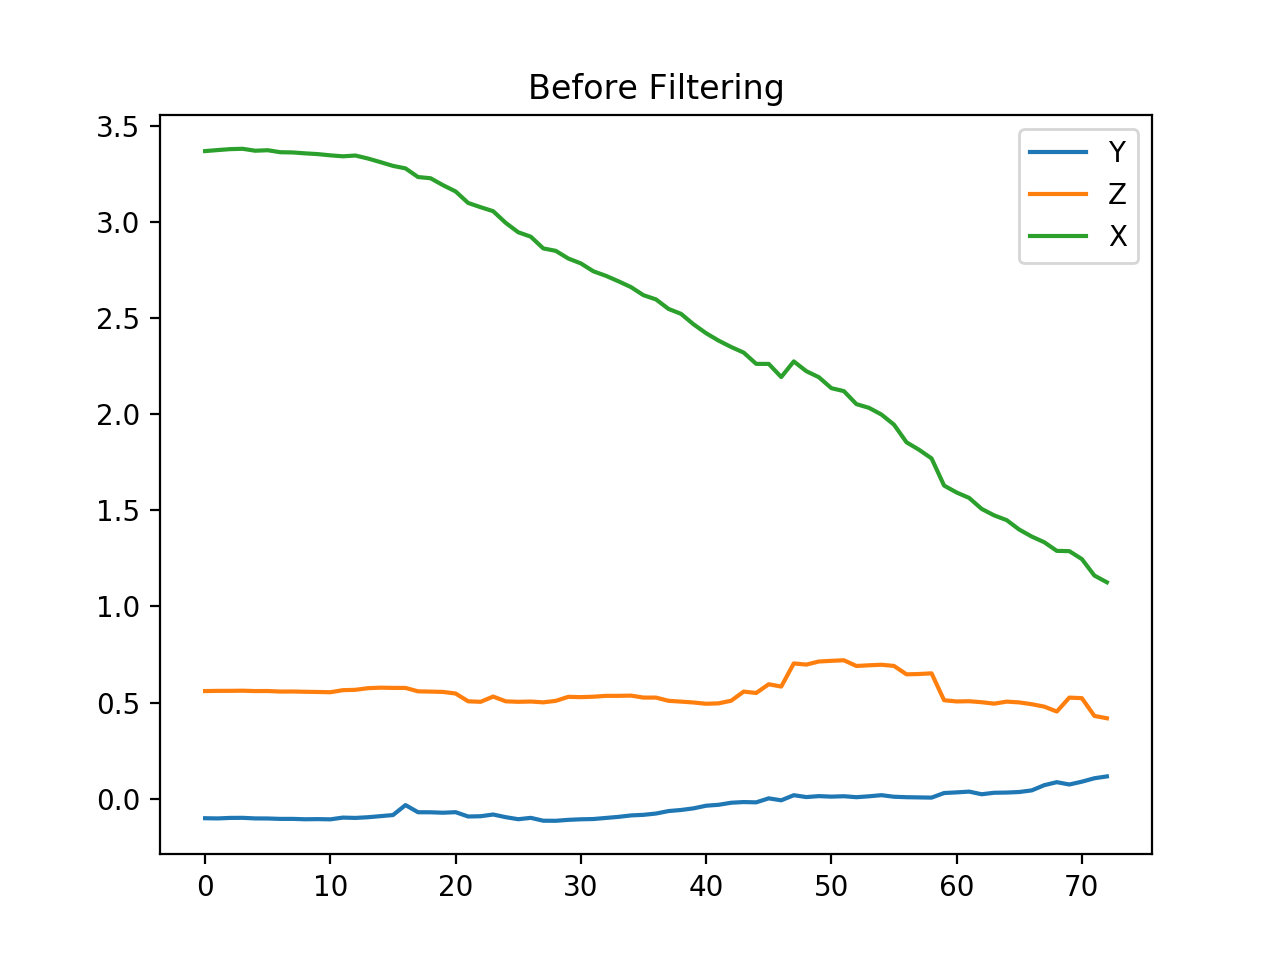

In [11]:
plt.figure()
plt.title("Before Filtering")
plt.plot(data_dict["0161134471"][0][0][:,2,:])
plt.legend(["Y","Z","X"])

<IPython.core.display.Javascript object>


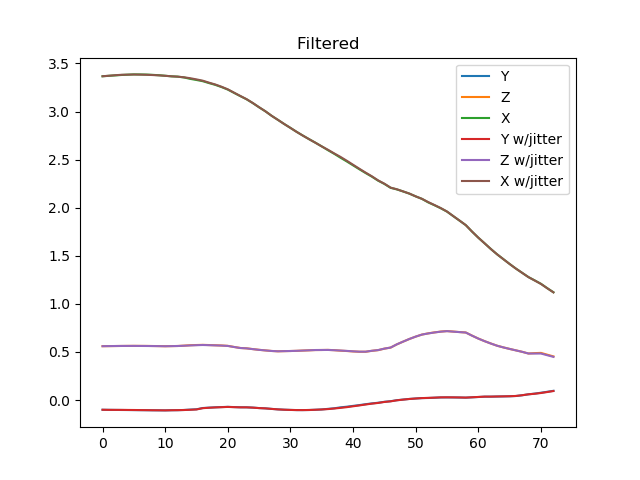

In [11]:
plt.figure()
plt.title("Filtered")
plt.plot(f_data["0161134471"][0][0][:,2,:])
plt.plot(f_data_jitter["0161134471"][0][0][:,2,:])
plt.legend(["Y","Z","X"] + ["Y w/jitter","Z w/jitter","X w/jitter"])

<IPython.core.display.Javascript object>


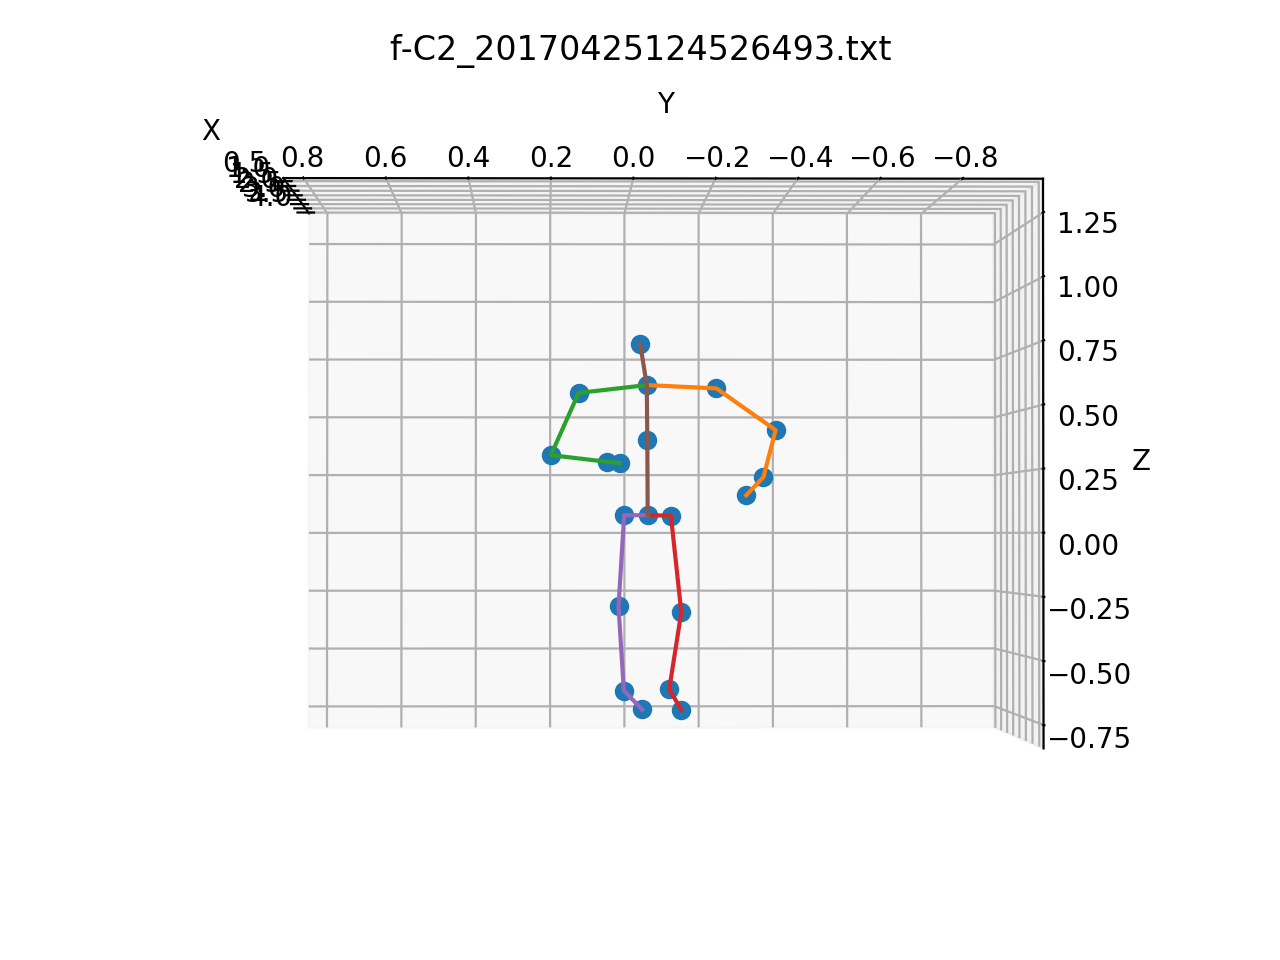

0


In [13]:
visualize_data(data_dict["1505497087"][0],draw_joints=True,draw_links=True,speed=100)

<IPython.core.display.Javascript object>


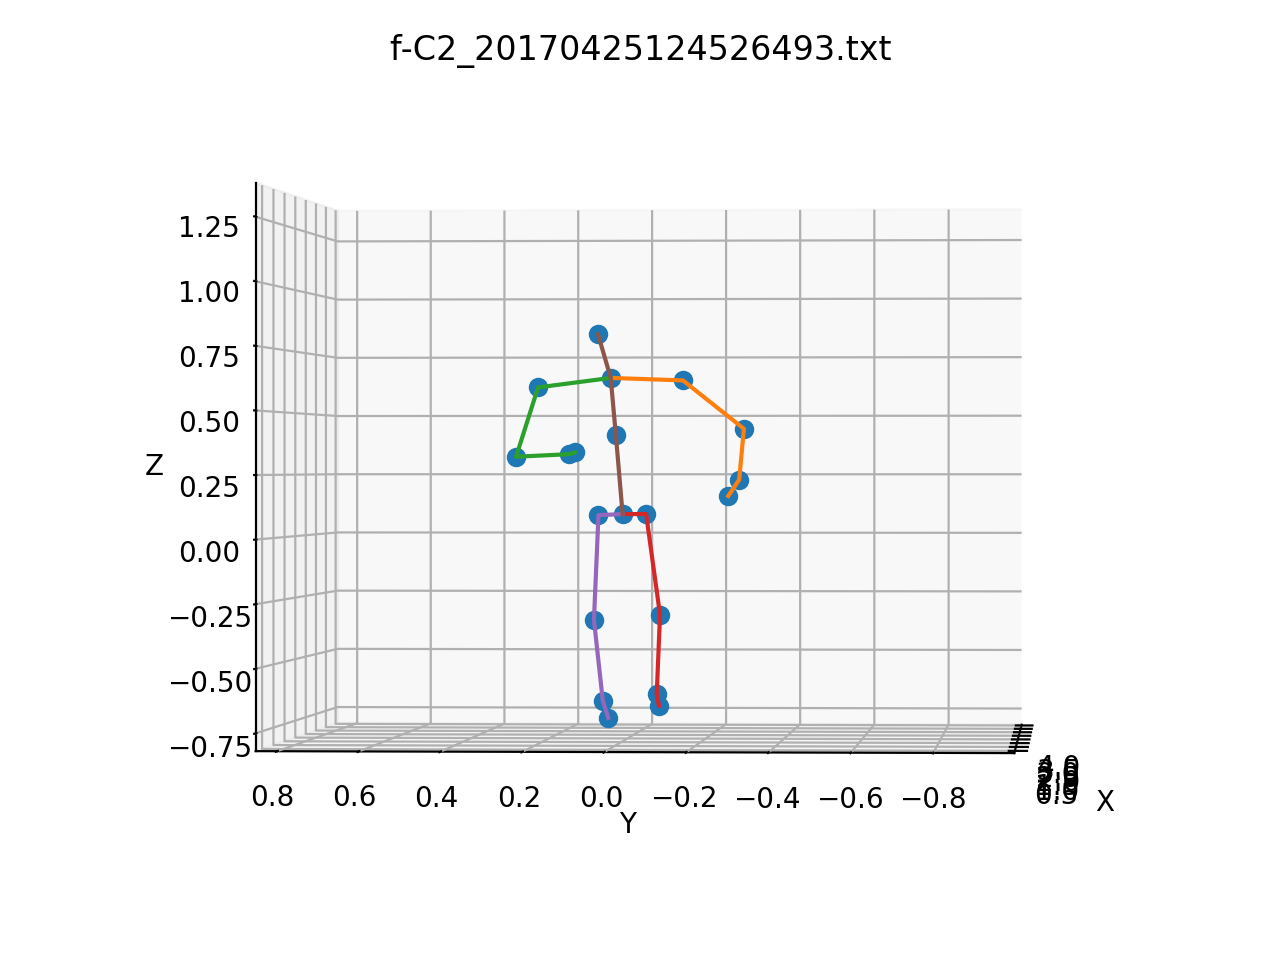

0


In [14]:
visualize_data(f_data["1505497087"][0],draw_joints=True,draw_links=True,speed=100)